In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter

%matplotlib inline

In [2]:
#set a random state
rs = 123

## Exploratory Data Analysis on Online Course Enrollment Data

Loading course rating dataset

In [3]:
course_rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
course_rating_df = pd.read_csv(course_rating_url)
course_rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [4]:
course_rating_df['rating'].unique()

array([3., 2.])

From database description - 3 stands for course completion, 2 - for viewing.

In [5]:
course_rating_df.shape[0]

233306

Number of unique users

In [6]:
unique_users = course_rating_df.groupby('user').size()
print(len(unique_users))
print(type(unique_users))
unique_users_df = pd.DataFrame(unique_users, columns = ['rating'])
print(unique_users_df)

33901
<class 'pandas.core.series.Series'>
         rating
user           
2            61
4            44
5            59
7             1
8             3
...         ...
2102054       8
2102356       1
2102680      11
2102983       1
2103039       1

[33901 rows x 1 columns]


Each user can be enrolled from 1 to many courses. Average course enrollment is 6.88:

In [7]:
print(len(course_rating_df)/len(unique_users_df))

6.8819798825993335


In [8]:
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"
course_genres_df = pd.read_csv(course_genre_url)
course_genres_df.head()

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [9]:
len(course_genres_df)

307

The feature names - course genres:

In [10]:
feature_names = list(course_genres_df.columns[2:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

## Data Featuring

Buidling user profiles dataset.
To build this dataset for a particular user, we need to multiply user's course rating to course genre vector and then sum allvalues for each of fourteen features across all courses this user was enrolled.

In [11]:
# Merging course geners and course rating datasets:
course_rating_df_copy = course_rating_df.copy()
course_rating_df_copy.rename(columns={'item': 'COURSE_ID'}, inplace=True)
merged_df = pd.merge(course_rating_df_copy, course_genres_df, on='COURSE_ID')
merged_df

,user,COURSE_ID,rating,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,1889878,CC0101EN,3.0,introduction to cloud,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1858700,CC0101EN,3.0,introduction to cloud,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1211012,CC0101EN,3.0,introduction to cloud,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,928820,CC0101EN,3.0,introduction to cloud,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1979095,CC0101EN,3.0,introduction to cloud,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233301,4,DB0115EN,2.0,db2 fundamentals ii,1,0,0,0,0,0,0,0,0,0,0,0,0,0
233302,5,DB0115EN,2.0,db2 fundamentals ii,1,0,0,0,0,0,0,0,0,0,0,0,0,0
233303,63,DB0115EN,2.0,db2 fundamentals ii,1,0,0,0,0,0,0,0,0,0,0,0,0,0
233304,435061,DB0115EN,2.0,db2 fundamentals ii,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Multiplying feature complumns by rating column
columns_to_multiply = merged_df.columns[4:18]  # Columns 5-17
merged_df[columns_to_multiply] = merged_df[columns_to_multiply].mul(merged_df['rating'], axis=0)
# Dropping columns not needed for user profile vectors
merged_df.drop(columns='rating', inplace=True)
merged_df.drop(columns='COURSE_ID', inplace=True)
merged_df.drop(columns='TITLE', inplace=True)
# Adding values for each feature across courses attended by user
user_profile_df = merged_df.groupby('user').sum()
user_profile_df.reset_index(inplace=True)
user_profile_df

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,2102054,3.0,3.0,3.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,6.0,0.0,3.0
33897,2102356,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33898,2102680,3.0,6.0,6.0,0.0,0.0,14.0,0.0,9.0,0.0,0.0,3.0,0.0,0.0,0.0
33899,2102983,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Loading user's course rating dataset (1000 users subset). For this users we want to make recommendations. We don't use the whole dataset to save computational time.

Creating subset of course_rating dataset for making recommendation. This subset will not be used for training but for recommendations only to save computational resourses. 

In [73]:
# Randomly choosing 1000 users
unique_users = user_profile_df['user'].unique()
random_users = pd.Series(unique_users).sample(n=1000, random_state=123)

In [74]:
#m Making a subset
test_users_df = course_rating_df[course_rating_df['user'].isin(random_users)]
test_users_df

,user,item,rating
11,1248617,CO0201EN,3.0
17,301887,DS0103EN,3.0
20,2098743,DV0101EN,3.0
71,83447,BD0131EN,2.0
98,504516,ML0101EN,3.0
...,...,...,...
233289,507699,BD0141EN,3.0
233291,711047,CB0103EN,2.0
233292,1983866,DV0151EN,3.0
233301,1540125,DS0101EN,3.0


In [75]:
unique_users = test_users_df.groupby('user').size()
print(len(unique_users))
print(type(unique_users))
unique_users_df = pd.DataFrame(unique_users, columns = ['rating'])
print(unique_users_df)

1000
<class 'pandas.core.series.Series'>
         rating
user           
26            1
66            1
13365         2
18169         6
31054         5
...         ...
2090799       1
2095450       1
2096268       5
2098743       7
2100731       8

[1000 rows x 1 columns]


Average course enrollment is 6.884:

In [76]:
print(len(test_users_df)/len(unique_users_df))

6.884


The average number of courses per user for subset is approximately the same as for original subset, so it can be assumed that subset represent dataset accurately.

In [24]:
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()
print(f"Total numbers of test users {len(test_user_ids)}")

Total numbers of test users 1000


## Content-based Course Recommender System Using User Profile and Course Genres

Calculation the recommendation scores of all courses for all the 1000 test users. Recommendation score for a course is a dot product of user profile vector and course profile vector. Only courses with recommendation score above the threshold is stored. Adjusting the threshold we can controll the number of recommended courses.

In [20]:
# The threshold for recommendations
score_threshold = 50.0

In [21]:
#the list of all available courses
all_courses = set(course_genres_df['COURSE_ID'].values)

Function generate_recommendation_scores() to compute the recommendation scores of all the unknown courses for all test users. 

In [26]:
def generate_recommendation_scores_threshold():
    users = []
    courses = []
    scores = []
    for user_id in test_user_ids:
        test_user_profile = user_profile_df[user_profile_df['user'] == user_id]
        # get user vector for the current user id
        test_user_vector = test_user_vector = test_user_profile.iloc[0, 1:].values
        
        # get the unknown course ids for the current user id
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
        unknown_courses = all_courses.difference(enrolled_courses)
        unknown_course_df = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
        unknown_course_ids = unknown_course_df['COURSE_ID'].values
        course_matrix = unknown_course_df.iloc[:, 2:].values
        
        # user np.dot() to get the recommendation scores for each course
        recommendation_scores = np.dot(course_matrix, test_user_vector)

        # Append the results into the users, courses, and scores list
        for i in range(0, len(unknown_course_ids)):
            score = recommendation_scores[i]
            # Only keep the courses with recommendation score above threshold
            if score >= score_threshold:
                users.append(user_id)
                courses.append(unknown_course_ids[i])
                scores.append(recommendation_scores[i])
                
    return users, courses, scores

Generating recommendation scores and save the courses recommendations into a dataframe with three columns: USER, COURSE_ID, SCORE:

In [27]:
users, courses, scores = generate_recommendation_scores_threshold()
#create an empty dictionary to store the results
res_dict = {}
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])

In [28]:
res_df

,USER,COURSE_ID,SCORE
0,56882,TMP0105EN,54.0
1,56882,excourse72,54.0
2,56882,excourse73,54.0
3,80186,RP0105EN,63.0
4,80186,TMP0105EN,63.0
...,...,...,...
872,2046749,excourse88,51.0
873,2046749,excourse89,51.0
874,2046749,excourse90,51.0
875,2046749,excourse92,51.0


In [29]:
#If run for threshold = 0, the minimal recommended value can be checked
#min_value = res_df['SCORE'].min()
#min_value

In [30]:
# Number of users with recommendations
print(res_df['USER'].nunique())

63


In [31]:
# Checking, how many new courses have been recommended per test user:
value_counts = res_df['USER'].value_counts()
value_counts.mean()

13.920634920634921

For threshold 10 the number of recommended courses is 61. The number of users, for whom recommendations wer made - 864. For threshold 50 - 9.6 courses in average.But the number of users with recommendations dropped to 72. Thus, it can be concluded, that method with threshold leave considerable number of not very active users without any recommendations.

Let's redo the recommender to keep Top-10 courses with the highest recommended score.

In [35]:
def generate_recommendation_scores():
    users = []
    courses = []
    scores = []
    for user_id in test_user_ids:
        test_user_profile = user_profile_df[user_profile_df['user'] == user_id]
        # get user vector for the current user id
        test_user_vector = test_user_vector = test_user_profile.iloc[0, 1:].values
        
        # get the unknown course ids for the current user id
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
        unknown_courses = all_courses.difference(enrolled_courses)
        unknown_course_df = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
        unknown_course_ids = unknown_course_df['COURSE_ID'].values
        course_matrix = unknown_course_df.iloc[:, 2:].values
        
        # user np.dot() to get the recommendation scores for each course
        recommendation_scores = np.dot(course_matrix, test_user_vector)

        # Append the results into the users, courses, and scores list
        for i in range(0, len(unknown_course_ids)):
            score = recommendation_scores[i]
            users.append(user_id)
            courses.append(unknown_course_ids[i])
            scores.append(recommendation_scores[i])
                
    return users, courses, scores

In [36]:
res_dict_2 = {}
users_2, courses_2, scores_2 = generate_recommendation_scores()
res_dict_2['USER'] = users_2
res_dict_2['COURSE_ID'] = courses_2
res_dict_2['SCORE'] = scores_2
res_2_df = pd.DataFrame(res_dict_2, columns=['USER', 'COURSE_ID', 'SCORE'])

In [37]:
res_2_df

,USER,COURSE_ID,SCORE
0,22,ML0201EN,0.0
1,22,GPXX0ZG0EN,0.0
2,22,RP0105EN,2.0
3,22,GPXX0Z2PEN,0.0
4,22,CNSC02EN,0.0
...,...,...,...
300088,2101142,excourse89,0.0
300089,2101142,excourse90,0.0
300090,2101142,excourse91,0.0
300091,2101142,excourse92,0.0


In [40]:
def keep_top_ten(df_group):
    return df_group.nlargest(10, 'SCORE')
content_top_ten_df = res_2_df.groupby('USER').apply(keep_top_ten)
content_top_ten_df = content_top_ten_df.reset_index(drop=True)

In [41]:
content_top_ten_df

,USER,COURSE_ID,SCORE
0,22,ML0101EN,6.0
1,22,excourse21,6.0
2,22,excourse22,6.0
3,22,DX0106EN,4.0
4,22,DX0108EN,4.0
...,...,...,...
9995,2101142,PA0107EN,2.0
9996,2101142,GPXX0IBEN,2.0
9997,2101142,TA0105,2.0
9998,2101142,SW0201EN,2.0


## Clustering-based Course Recommender System

Performing K-means clustering on user profile feature vectors

First, checking summary statistics

In [42]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,5.518569,3.493791,2.307100,3.624701,0.998938,3.048022,0.001770,5.087343,4.750450,0.462995,1.017433,2.269461,0.315802,0.986844
std,4.972578e+05,7.611941,4.227254,3.841858,4.760135,2.351764,4.624004,0.072846,5.230697,7.216228,1.055186,2.342532,4.310752,1.363462,1.950585
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,9.000000,6.000000,3.000000,6.000000,0.000000,3.000000,0.000000,9.000000,6.000000,0.000000,0.000000,3.000000,0.000000,2.000000
max,2.103039e+06,63.000000,18.000000,38.000000,48.000000,15.000000,39.000000,3.000000,32.000000,54.000000,6.000000,18.000000,54.000000,15.000000,12.000000


The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefor we standardize the data.

In [43]:
user_profile_scaled_df = user_profile_df.copy()

# Use StandardScaler to make each feature with mean 0, standard deviation 1
scaler = StandardScaler()

# Standardizing the selected features (feature_names) in the user_profile_df DataFrame
user_profile_scaled_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])

print("mean {} and standard deviation{} ".format(user_profile_df[feature_names].mean(), user_profile_df[feature_names].std()))

mean Database           5.518569
Python             3.493791
CloudComputing     2.307100
DataAnalysis       3.624701
Containers         0.998938
MachineLearning    3.048022
ComputerVision     0.001770
DataScience        5.087343
BigData            4.750450
Chatbot            0.462995
R                  1.017433
BackendDev         2.269461
FrontendDev        0.315802
Blockchain         0.986844
dtype: float64 and standard deviationDatabase           7.611941
Python             4.227254
CloudComputing     3.841858
DataAnalysis       4.760135
Containers         2.351764
MachineLearning    4.624004
ComputerVision     0.072846
DataScience        5.230697
BigData            7.216228
Chatbot            1.055186
R                  2.342532
BackendDev         4.310752
FrontendDev        1.363462
Blockchain         1.950585
dtype: float64 


In [44]:
user_profile_scaled_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,1.064064e+06,-3.353495e-17,-5.700942e-17,-3.521170e-17,-7.671120e-17,3.353495e-18,3.688845e-17,-1.509073e-17,-1.676748e-17,6.706990e-17,-6.874665e-17,4.233788e-17,1.383317e-17,5.051202e-17,-5.281755e-17
std,4.972578e+05,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2.000000e+00,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
25%,6.813480e+05,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
50%,1.043907e+06,-3.308757e-01,-1.168130e-01,-6.005256e-01,-1.312380e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-3.990622e-01,-3.811535e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
75%,1.451159e+06,4.573712e-01,5.928781e-01,1.803581e-01,4.990056e-01,-4.247674e-01,-1.038556e-02,-2.429612e-02,7.480294e-01,1.731609e-01,-4.387873e-01,-4.343370e-01,1.694715e-01,-2.316212e-01,5.194189e-01
max,2.103039e+06,7.551593e+00,3.431642e+00,9.290667e+00,9.322416e+00,5.953517e+00,7.775190e+00,4.115884e+01,5.145214e+00,6.824934e+00,5.247500e+00,7.249771e+00,1.200053e+01,1.076995e+01,5.646161e+00


The normalized user profile features are:

In [45]:
features = user_profile_scaled_df.loc[:, user_profile_scaled_df.columns != 'user']
features

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


Saving users ids

In [46]:
user_ids = user_profile_scaled_df.loc[:, user_profile_scaled_df.columns == 'user']
user_ids

,user
0,2
1,4
2,5
3,7
4,8
...,...
33896,2102054
33897,2102356
33898,2102680
33899,2102983


Using the KMeans class provided by scikit-learn library to perform clustering on the user profile feature vectors.

For KMeans algorithm, one important hyperparameter is the number of clusters n_cluster. To optimise number of clusters, the grid search is used, evaluation metrics such as minimal sum of squared distance is calculated and the number of clusters is chosen, using elbow method.

In [47]:
import warnings
warnings.filterwarnings('ignore')
sum_of_square_distances = []
n_clusters = range(1, 30)
for k in n_clusters:
    model = KMeans(n_clusters = k, random_state = rs).fit(features)
    sum_of_square_distances.append(model.inertia_)

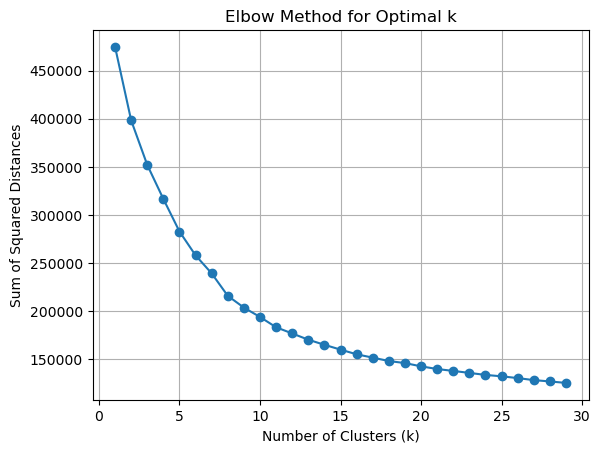

In [48]:
# Elbow method
plt.plot(n_clusters, sum_of_square_distances, marker='o')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

From the elbow plot, we can visualy identify the point where the metric starting to be flatten, which indicates the optimized number of clusters. From this graph it is difficult to choose the number univocally since there is no obvious elbow point. I'm going to choose 18. 

Generating cluster labels

In [49]:
cluster_labels = [None] * len(user_ids)
model = KMeans(n_clusters = 18, random_state = rs).fit(features)
cluster_labels = model.labels_
cluster_labels

array([ 1,  1, 11, ...,  5,  3,  3], dtype=int32)

Function to combine users id with the clusters

In [50]:
def combine_cluster_labels(user_ids, labels):
    # Convert labels to a DataFrame
    labels_df = pd.DataFrame(labels)    
    # Merge user_ids DataFrame with labels DataFrame based on index
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [51]:
clusters_df = combine_cluster_labels(user_ids, cluster_labels)
clusters_df

,user,cluster
0,2,1
1,4,1
2,5,11
3,7,3
4,8,3
...,...,...
33896,2102054,15
33897,2102356,3
33898,2102680,5
33899,2102983,3


We can say we have created many clusters of learning communities. Learners within each community share very similar learning interests.

### Applying PCA to reduce dimension

In [52]:
# Extracting features from the user_profile_df, excluding the 'user' column
features = user_profile_scaled_df.loc[:, user_profile_scaled_df.columns != 'user']

# Extracting user IDs from the user_profile_df DataFrame
user_ids = user_profile_scaled_df.loc[:, user_profile_scaled_df.columns == 'user']

# Creating a list of feature names by excluding the 'user' column name
feature_names = list(user_profile_scaled_df.columns[1:])

In [53]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


Plotting covariance matrix to check if there are any correlated features

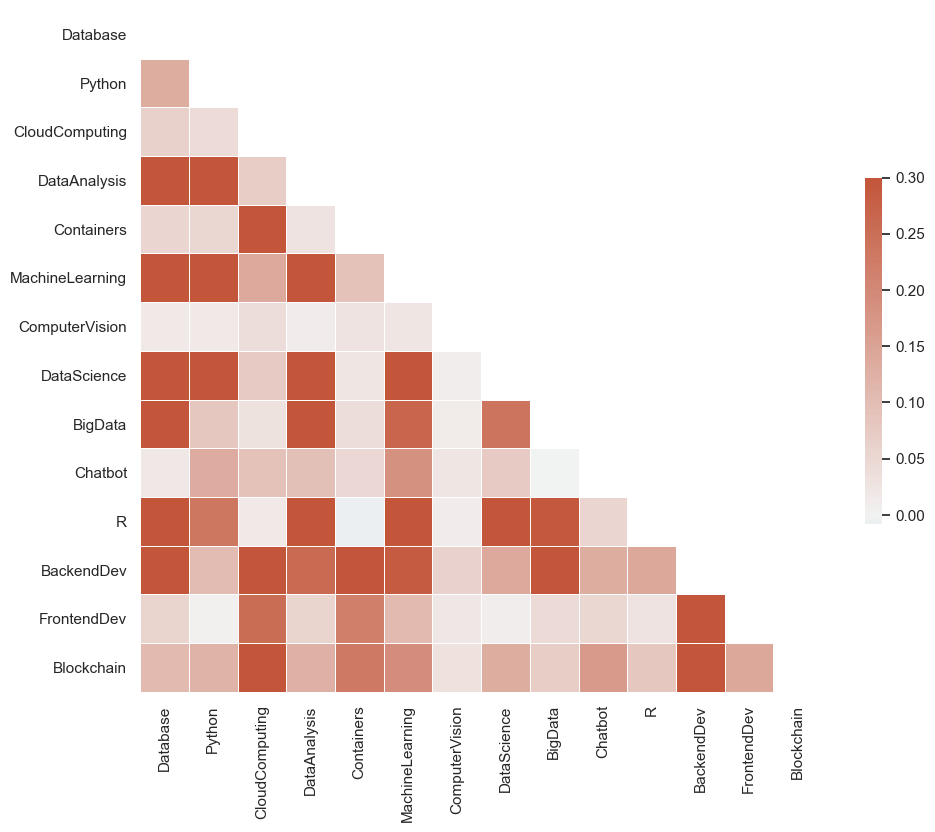

In [54]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

Some of the featres are correlated. If we only keep the independent main components, then we can reduce the dimensions of our user profile feature vectors.

To reduce dimensionality, the `PCA()` provided by  `scikit-learn` will be performed to find the main components in user profile feature vectors and see if we can reduce its dimensions by only keeping the main components.

To find the optimised number of components to keep, the grid search will be performed and the ratio of the accumulated variance for each candidate will be calculated.

If the accumulated variances ratio of a candidate n_components is larger than a threshold, e.g., 90%, then we can say the transformed n_components could explain about 90% of variances of the original data variance and can be considered as an optimized components size.

In [55]:
accumulated_variance_ratios = []
n_components = range(1,15)
for component in n_components:
    pca = PCA(n_components=component)
    pca.fit_transform(features)
    accumulated_variance_ratios.append(pca.explained_variance_ratio_.sum())

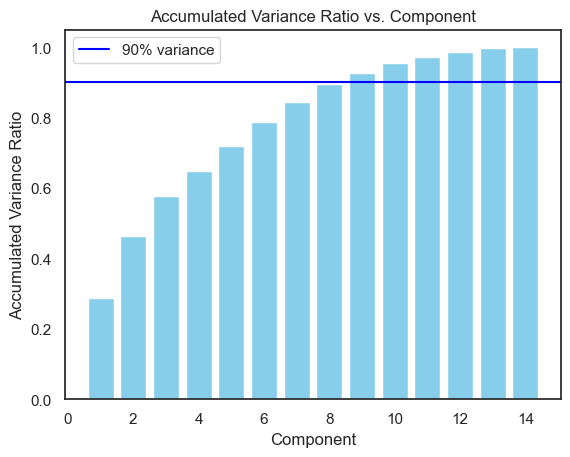

In [56]:
# Plotting accumulated variance
plt.bar(n_components, accumulated_variance_ratios, color = 'skyblue')

# Add a horizontal threshold line at y=0.9
plt.axhline(y=0.9, color='blue', linestyle='-', label='90% variance')

plt.xlabel('Component')
plt.ylabel('Accumulated Variance Ratio')
plt.title('Accumulated Variance Ratio vs. Component')
plt.legend()
plt.show()

As it can be seen, we can keep 9 main components with variance ratio over 90%

Applying PCA on the user profile feature vectors and reduce the 14 features into n_component=9 features.

In [57]:
pca = PCA(n_components = 9)
components=pca.fit_transform(features)
components_df = pd.DataFrame(data = components)
components_users_df = pd.merge(user_ids, components_df, left_index=True, right_index=True)
components_df

,0,1,2,3,4,5,6,7,8
0,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379
...,...,...,...,...,...,...,...,...,...
33896,0.633824,0.108815,-0.388871,-0.122665,-0.098364,0.358333,1.752049,1.486542,-0.523600
33897,-2.095339,0.135058,0.244727,-0.088185,0.025081,0.183641,0.046413,0.191709,0.260437
33898,0.625943,-0.547167,-1.692824,-0.630589,0.166632,0.676244,-0.055100,0.582091,1.703193
33899,-2.036832,-0.153534,0.162852,0.082651,-0.126419,0.255109,0.072496,0.113750,0.622900


### Performing k-means clustering on the PCA transformed feature vectors

In [58]:
import warnings
warnings.filterwarnings('ignore')
sum_of_square_distances = []
n_clusters = range(1, 30)
for k in n_clusters:
    model = KMeans(n_clusters = k, random_state = rs).fit(components_df)
    sum_of_square_distances.append(model.inertia_)

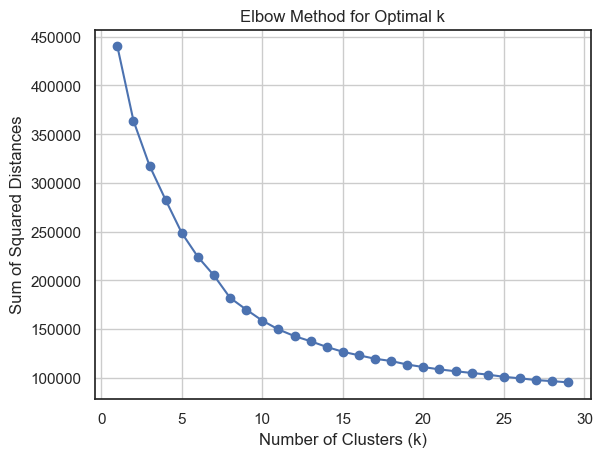

In [59]:
plt.plot(n_clusters, sum_of_square_distances, marker='o')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [60]:
cluster_labels = [None] * len(user_ids)
model = KMeans(n_clusters = 18, random_state = rs).fit(components_df)
cluster_labels = model.labels_
clusters_df = combine_cluster_labels(user_ids, cluster_labels)
clusters_df

,user,cluster
0,2,16
1,4,14
2,5,16
3,7,1
4,8,1
...,...,...
33896,2102054,4
33897,2102356,1
33898,2102680,9
33899,2102983,1


### Generating course recommendations based on the popular courses in the same cluster

The recommendations will be generated for reduced database with 1000 users as in previous case

In [61]:
test_users_2_df = test_users_df[['user', 'item']]
#Assigning clusters for test users
test_users_labelled = pd.merge(test_users_2_df, clusters_df, left_on='user', right_on='user')
test_users_labelled

,user,item,cluster
0,1741605,DS0103EN,6
1,1741605,ML0103EN,6
2,1741605,DS0101EN,6
3,1741605,PY0101EN,6
4,1741605,DB0101EN,6
...,...,...,...
6902,1289347,CNSC02EN,1
6903,719761,CB0103EN,13
6904,674361,CNSC02EN,1
6905,1106966,CL0101EN,1


Counting the enrollments for each course in each group

In [62]:
# Extracting the 'item' and 'cluster' columns from the test_users_labelled DataFrame
courses_cluster = test_users_labelled[['item', 'cluster']]

# Adding a new column 'count' with a value of 1 for each row in the courses_cluster DataFrame
courses_cluster['count'] = [1] * len(courses_cluster)

# Grouping the DataFrame by 'cluster' and 'item', aggregating the 'count' column with the sum function,
# and resetting the index to make the result more readable
courses_cluster_grouped = courses_cluster.groupby(['cluster','item']).agg(enrollments=('count','sum')).reset_index()
sorted_courses_cluster_grouped = courses_cluster_grouped.sort_values(by=['cluster', 'enrollments'], ascending=[True, False])
sorted_courses_cluster_grouped

,cluster,item,enrollments
43,0,PY0101EN,56
15,0,DA0101EN,52
23,0,DV0101EN,51
31,0,ML0101ENv3,45
34,0,ML0115EN,32
...,...,...,...
986,17,ML0151EN,1
989,17,PHPM002EN,1
991,17,RP0101EN,1
992,17,SC0101EN,1


For each user, finding enrollement courses and cluster, then determine unseen courses from its cluster and choose 10 most popular ones

In [63]:
test_users_ids = test_users_labelled['user'].unique()
columns = ['user'] + [str(i) for i in range(1, 11)]
cluster_top_ten_df = pd.DataFrame(columns=columns)
for id in test_users_ids:
    #extract information about user - entrolled courses and cluster
    user_subset = test_users_labelled[test_users_labelled['user'] == id]
    enrolled_courses = user_subset['item']
    enrolled_courses = set(enrolled_courses)
    cluster = user_subset['cluster'].iloc[0]
    #find unseen courses for the user: all courses for this cluster - enrolled courses for the user
    all_courses = set(sorted_courses_cluster_grouped[sorted_courses_cluster_grouped['cluster']==cluster]['item'].values)
    #all_courses = set(test_users_labelled[test_users_labelled['cluster'] == cluster]['item'].values)
    unknown_courses = all_courses.difference(enrolled_courses)
    #recommend ten most popular courses from unseen list to the user
    cluster_group = sorted_courses_cluster_grouped[sorted_courses_cluster_grouped['cluster'] == cluster]
    chosen_courses = []
    for index, row in cluster_group.iterrows():
    # Check if the course is in the unknown_courses list and if we have not already chose 10 courses
        if row['item'] in unknown_courses and len(chosen_courses) < 10:
            # Add the course to the chosen_courses list
            chosen_courses.append(row['item'])
    #print(chosen_courses)
    #print('----------------------')
    data = {'user': id}
    for i, course in enumerate(chosen_courses, start=1):
        data[str(i)] = course
    cluster_top_ten_df = cluster_top_ten_df._append(data, ignore_index=True)

In [64]:
cluster_top_ten_df

,user,1,2,3,4,5,6,7,8,9,10
0,1741605,BD0101EN,DA0101EN,DS0105EN,DV0101EN,BD0111EN,ML0101ENv3,CC0101EN,DS0301EN,BD0211EN,CC0103EN
1,1383,BD0211EN,BD0115EN,DS0101EN,BD0131EN,PY0101EN,BD0212EN,DS0103EN,BD0121EN,SC0101EN,DB0151EN
2,879134,ML0101ENv3,DB0101EN,ST0101EN,BD0101EN,BC0101EN,DS0301EN,BD0111EN,BD0211EN,PA0101EN,CC0101EN
3,1740936,PY0101EN,ML0101ENv3,ML0115EN,BC0201EN,DA0101EN,CO0101EN,ML0120ENv2,CL0101EN,DB0101EN,BC0202EN
4,1464410,RP0101EN,ST0101EN,ML0151EN,PA0101EN,BC0101EN,DV0151EN,ML0103EN,DS0301EN,CB0103EN,DB0101EN
...,...,...,...,...,...,...,...,...,...,...,...
995,1289347,DS0101EN,BD0101EN,BC0201EN,ML0122ENv1,ST0101EN,CL0101EN,DAI101EN,DS0103EN,BD0111EN,CC0101EN
996,719761,BD0101EN,DS0101EN,BD0111EN,CC0101EN,PY0101EN,RP0101EN,WA0101EN,BD0211EN,DS0103EN,DS0105EN
997,674361,DS0101EN,BD0101EN,BC0201EN,ML0122ENv1,ST0101EN,CL0101EN,DAI101EN,DS0103EN,BD0111EN,CC0101EN
998,1106966,CNSC02EN,DS0101EN,BD0101EN,BC0201EN,ML0122ENv1,ST0101EN,DAI101EN,DS0103EN,BD0111EN,CC0101EN


## Comparison of the Results

Checking that users ids are the same in both result DataFrames

In [65]:
user_ids_content = set(content_top_ten_df['USER'].unique())

# Extract unique user IDs from the second DataFrame
user_ids_cluster = set(cluster_top_ten_df['user'].unique())

# Check if the sets of unique user IDs are identical
if user_ids_content == user_ids_cluster:
    print("User IDs are identical in both DataFrames.")
else:
    print("User IDs are not identical in both DataFrames.")

User IDs are identical in both DataFrames.


Calculating the percentage of intersection between recommendations, obtained b content-base and clustering based methods

In [66]:
similarity = []
for user_id in user_ids_cluster:
    user_content = content_top_ten_df[content_top_ten_df['USER'] == user_id]
    course_names_content = user_content['COURSE_ID'].unique()
    course_names_cluster = cluster_top_ten_df.loc[cluster_top_ten_df['user'] == user_id].iloc[:, 1:].values #.tolist()[0]
    course_names_cluster = np.array(course_names_cluster).flatten()
    set_content = set(course_names_content)
    set_cluster = set(course_names_cluster)
    common_elements = set_content.intersection(set_cluster)
    percentage_common = len(common_elements) / len(set_cluster) * 100
    similarity.append(percentage_common)

In [67]:
# Checking the number of each percentage appearance
frequency = Counter(similarity)
for value, count in frequency.items():
    print(f"Value {value}: Frequency {count}")

Value 30.0: Frequency 26
Value 0.0: Frequency 622
Value 10.0: Frequency 219
Value 50.0: Frequency 24
Value 40.0: Frequency 58
Value 20.0: Frequency 39
Value 60.0: Frequency 12


In [68]:
# The average intersection
average = sum(similarity) / len(similarity)
print("Average:", average)

Average: 7.99


As it can be seen, profile-content-based and cluster-based approaches provided very different results. Theoretically, the reason may lay in fact, that users are interested in various courses to increase their expertise while content based recommendations assume the great similarity of courses. Ideally, the live test of method could reveal which one is more effective. Meantime, the other approaches can be utilised (content-BoW method, deep learning methods) and compared with suggested above. 